In [15]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float
def get_exit_time(config, lr, sharpness):
    sqrt_s = np.sqrt(sharpness)
    exit_time_arr = np.zeros(config['exit_trial_num'])
    for sample_id in range(config['exit_trial_num']):
        # Define Origin to a minimum
        # Styblinski-Tang
        # init_params = (-2.903534/sqrt_s) * torch.ones((1, config['num_dim']), device=device, dtype=dtype)
        # params = (-2.903534/sqrt_s) * torch.ones((1, config['num_dim']), device=device, dtype=dtype)
        # Quadratic func
        init_params = (0/sqrt_s) * torch.ones((1, config['num_dim']), device=device, dtype=dtype)
        params = (0/sqrt_s) * torch.ones((1, config['num_dim']), device=device, dtype=dtype)
        #
        params.requires_grad=True
        exit_time = 0
        while(torch.norm(params-init_params) < config['r']):
            # Styblinski-Tang
            # func = 0.5 * ((sqrt_s*params) ** 4 - 16 * (sqrt_s*params) ** 2 + 5 * (sqrt_s*params)).sum(dim=1)
            # Quadratic func
            func = ((sqrt_s*params) ** 2).sum(dim=1)
            func.backward()
            with torch.no_grad():
                params -= lr*params.grad
                params -= 0.1*torch.randn(config['num_dim'], device=device, dtype=dtype)
            exit_time += 1
        exit_time_arr[sample_id] = exit_time
    return np.mean(exit_time_arr), np.std(exit_time_arr)


2022-01-25 08:22:03.186367 use GPU; core:0


NameError: name 'x' is not defined

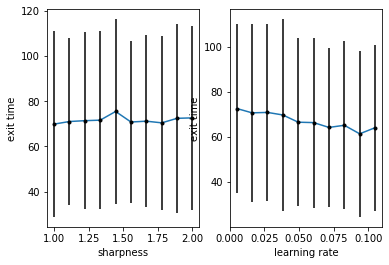

In [20]:
from utility import *
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import sys
import optuna
from mpi4py import MPI
%matplotlib inline
def main():
    config = {}
    config['core'] = 0
    config['seed'] = -1
    config['num_dim'] = 2
    config['sharpness_min'] = 1
    config['sharpness_interval'] = 1
    config['r'] = 1
    config['lr_min'] = 0.005
    config['lr_interval'] = 0.1
    config['exit_trial_num'] = 500
    config['interval_sample'] = 10

    set_device(config)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Sharpess
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    data = np.zeros(1000)
    sharpness_arr = np.linspace(config['sharpness_min'], 
                                 config['sharpness_min']+config['sharpness_interval'],
                                 config['interval_sample'])
    exit_time_arr = np.zeros((0,1))
    std_arr = np.zeros((0,1))
    for sharpness in sharpness_arr:
        mean, std = get_exit_time(config, config['lr_min'], sharpness)
        exit_time_arr = np.append(exit_time_arr, mean)
        std_arr = np.append(std_arr, std)
    ax1.set_xlabel("sharpness")
    ax1.set_ylabel("exit time")
    ax1.errorbar(sharpness_arr, exit_time_arr, yerr=std_arr, fmt='.k') 
    ax1.plot(sharpness_arr, exit_time_arr) 
    # Learning rate
    lr_arr = np.linspace(config['lr_min'],
                          config['lr_min']+config['lr_interval'],
                          config['interval_sample'])
    exit_time_arr = np.zeros((0,1))
    std_arr = np.zeros((0,1))
    for lr in lr_arr:
        mean, std = get_exit_time(config, config['sharpness_min'], lr)
        exit_time_arr = np.append(exit_time_arr, mean)
        std_arr = np.append(std_arr, std)
    ax2.set_xlabel("learning rate")
    ax2.set_ylabel("exit time")
    ax2.errorbar(lr_arr, exit_time_arr, yerr=std_arr, fmt='.k') 
    ax2.plot(lr_arr, exit_time_arr)
    # A = np.vstack([x, np.ones(len(x))]).T
    # lr_m, _ = np.linalg.lstsq(A, y, rcond=None)[0]
    

if __name__=='__main__':
    main()

In [ ]:
# def exit_time(dataset, model, config):
#     if config.noise == "iso":
#         config.batch_size = dataset.train.n
#     origin = copy.deepcopy(model)
#     loss_func = get_loss(config)
#     optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, weight_decay=1e-5, momentum=0.9)

#     def step():
#         model.train()
#         measure = {'loss':0,'accuracy':0}
#         random_index = torch.randperm(dataset.train.n)
#         gd_model = copy.deepcopy(model)
#         gd_model.zero_grad()
#         # Full batch gradient
#         x = dataset.train.x
#         y = dataset.train.y
#         o = gd_model(x)
#         loss_func(o,y).backward()
#         if config.noise == "aniso":
#             sgd_model = copy.deepcopy(model)
#             sgd_model.zero_grad()
#             # Mini batch gradient
#             mini_batch = random_index[:config.batch_size]
#             x = dataset.train.x[mini_batch]
#             y = dataset.train.y[mini_batch]
#             o = sgd_model(x)
#             loss_func(o,y).backward()
#         if config.noise == "iso":
#             with torch.no_grad():
#                 for p, gd_p in zip(model.parameters(), gd_model.parameters()):
#                     if p.requires_grad:
#                         p -= config.lr*gd_p.grad
#                         p += config.epsilon*torch.randn(p.shape).cuda()
#         elif config.noise == "aniso":
#             with torch.no_grad():
#                 for p, gd_p, sgd_p in zip(model.parameters(), gd_model.parameters(), sgd_model.parameters()):
#                     if p.requires_grad:
#                         p -= config.lr*gd_p.grad
#                         p -= config.epsilon*(sgd_p.grad - gd_p.grad)


#     def l2_deviation():
#         l2_distance = 0 
#         for origin_param, perturbed_param in zip(origin.parameters(), model.parameters()) :
#             deviation = perturbed_param.data - origin_param.data
#             l2_distance += torch.norm(deviation, 2).item()
#         return l2_distance

#     iteration = 0
#     while l2_deviation() < config.r:
#         iteration += 1
#         step()
#     return iteration